### FFNN hypertuning

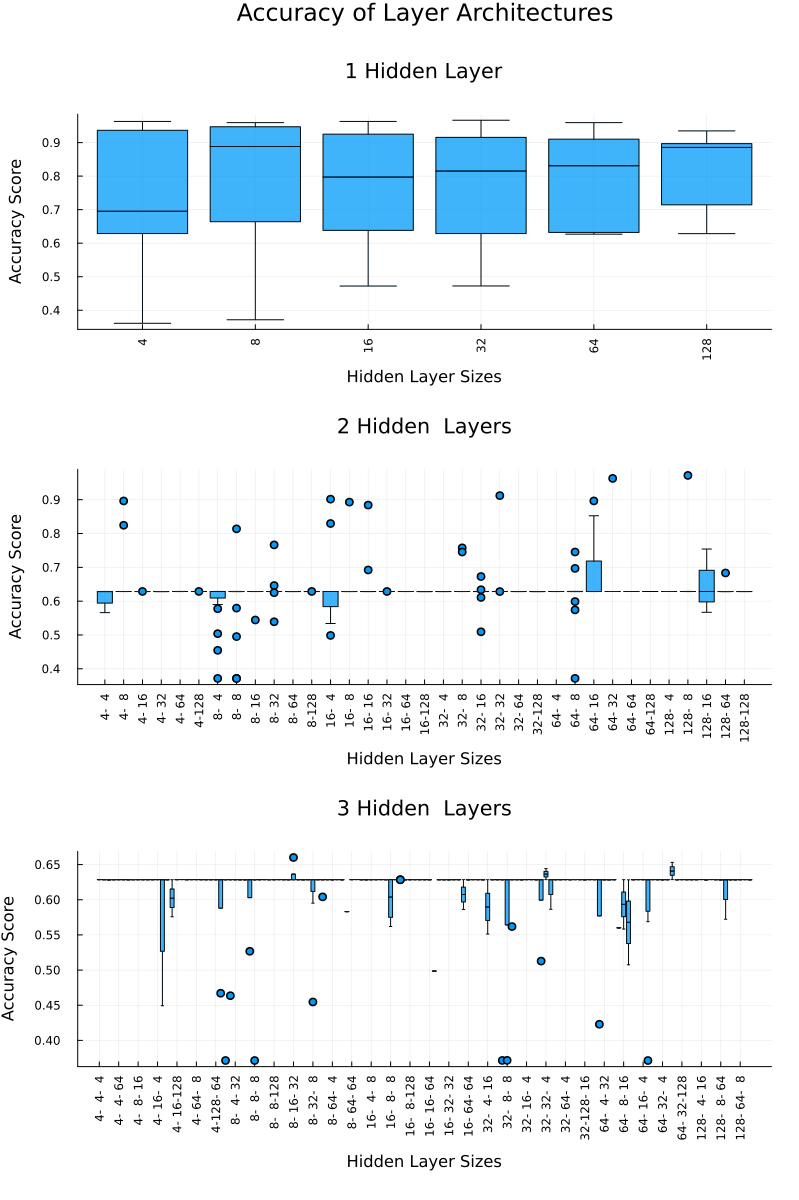

In [1]:
include("../code/activation.jl")
include("../code/cost.jl")
include("../code/data.jl")
include("../code/hypertuning.jl")

using Plots

Random.seed!(0)

n_samples = 1000
noise_amplitude = 0.01
random_inputs = false

X, y = fetch_wisconsin_breast_cancer_data()
X_scaled = standardize_data(X)
Y = reshape(y, (length(y), 1))

model_functions = NetworkFunctions(
  sigmoid,
  sigmoid_prime,
  sigmoid,
  sigmoid,
  binary_cross_entropy,
  binary_cross_entropy_prime
)

best_params, all_results = random_search_classification(
  X_scaled, Y,
  model_functions,
  k_folds=5,
  epochs=100,
  batch_size=32,
  trials=1000,
)

final_plot, best_results = visualize_architecture_tuning_classification(all_results)
display(final_plot)
#println(best_results)

In [ ]:
include("../code/activation.jl")
include("../code/cost.jl")
include("../code/data.jl")
include("../code/neural_network.jl")
include("../code/hypertuning.jl")
include("../code/regression.jl")
include("../code/utils.jl")

using DataFrames
using DataStructures
using Random

Random.seed!(0)

data = Vector{BinaryModelScore}()

# Generate data
n_samples = 1000
noise_amplitude = 0.01
random_inputs = false

X, y = fetch_wisconsin_breast_cancer_data()
X_scaled = standardize_data(X)
Y = reshape(y, (length(y), 1))

# Evaluate FFNN
layer_sizes = [size(X, 2), 32, 16, 1]
lr = 0.001
l2_lambda = 1e-4

k_folds = 10
n_epochs = 1000
batch_size = 32

ffnn_models = OrderedDict(
  "FFNN (sigmoid)" => (sigmoid, sigmoid_prime),
  "FFNN (ReLU)" => (relu, relu_prime),
  "FFNN (LReLU)" => (leaky_relu, leaky_relu_prime)
)

for (model_name, (activation, activation_prime)) in ffnn_models
  model = initialize_network(
    layer_sizes,
    activation, activation_prime,
    sigmoid, sigmoid_prime,
    binary_cross_entropy, binary_cross_entropy_prime,
    ConstantLR(lr),
    l2_lambda
  )

  accuracy_ffnn, time_ffnn =
    evaluate_network_classification(X_scaled, Y, model, k_folds, n_epochs, batch_size)
  ffnn_score = network_scores(model_name, accuracy_ffnn, time_ffnn)
  push!(data, ffnn_score)
end

# Evaluate logistic regression
logreg_model = LogisticRegression(lr, l2_lambda, 1000)
accuracy_logreg, time_logreg = evaluate_logistic_model(
  X_scaled, y,
  logistic_model=logreg_model,
  k_folds=k_folds,
)

logreg_score = network_scores("LogReg", accuracy_logreg, time_logreg)
push!(data, logreg_score)

df = DataFrame(
  model=[d.model for d in data],
  accuracy=[d.accuracy_mean_std[1] for d in data],
  accuracy_std=[d.accuracy_mean_std[2] for d in data],
  time=[d.time_mean_std[1] for d in data],
  time_std=[d.time_mean_std[2] for d in data],
)

display(df)
headers = OrderedDict{String,Union{Symbol,Tuple{Symbol,Symbol}}}(
  "Model" => :model,
  "Accuracy" => (:accuracy, :accuracy_std),
  "Time [s]" => (:time, :time_std),
)

markdown_table = dataframe_to_markdown_table(df, headers)
open("classification_models_table.txt", "w") do io
  write(io, markdown_table)
end


Row,model,accuracy,accuracy_std,time,time_std
,String,Float64,Float64,Float64,Float64
1,FFNN (sigmoid),0.62854,0.0588057,1.27697,0.239609
2,FFNN (ReLU),0.97359,0.0238718,0.709686,0.0982249
3,FFNN (LReLU),0.975345,0.0207368,0.751873,0.106093
4,LogReg,0.955952,0.0278523,0.0143038,0.00532134


418